In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
! git clone https://github.com/HoangDuonng1359/Chest-X-Ray.git

Cloning into 'Chest-X-Ray'...
remote: Enumerating objects: 5119, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5119 (delta 0), reused 0 (delta 0), pack-reused 5117 (from 5)
Receiving objects: 100% (5119/5119), 1.99 GiB | 54.53 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (5008/5008), done.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import os
from PIL import Image
from typing import Tuple
from tqdm.auto import tqdm, trange
import torchvision.transforms.functional as f


In [4]:
train_df = pd.read_csv("Chest-X-Ray/data/train_effusion.csv")
valid_df = pd.read_csv("Chest-X-Ray/data/val_effusion.csv")
test_df = pd.read_csv("Chest-X-Ray/data/test_effusion.csv")

train_df.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00016449_002.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,16449
1,00029052_005.png,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,29052
2,00028655_001.png,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28655
3,00029373_001.png,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,29373
4,00000138_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,138


In [5]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [6]:
class ChestXrayBinaryDataset(Dataset):
    def __init__(self, df, image_dir, label_name, transform=None):
        """
        df: DataFrame chứa thông tin ảnh và nhãn
        image_dir: Thư mục chứa ảnh
        label_name: Tên của nhãn cần phân loại (chuỗi)
        transform: Các phép biến đổi ảnh (nếu có)
        """
        self.df = df
        self.image_dir = image_dir
        self.label_name = label_name
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Đọc ảnh
        image_path = f"{self.image_dir}/{self.df.iloc[idx]['id']}"
        image = Image.open(image_path).convert("RGB")

        # Lấy nhãn dạng nhị phân (0 hoặc 1)
        label = torch.tensor(
            self.df.iloc[idx][self.label_name], dtype=torch.float32
        )

        # Biến đổi ảnh (nếu có)
        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
import random
class RandomBottomCrop(object):
    def __init__(self, crop_height_ratio=0.5):
        self.crop_height_ratio = crop_height_ratio

    def __call__(self, img):
        w, h = img.size
        crop_h = int(h * self.crop_height_ratio)
        max_start = h - crop_h
        start_y = random.randint(max_start - crop_h//3, max_start)
        return img.crop((0, start_y, w, start_y + crop_h))

In [8]:
transform_train = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),  
    transforms.Resize((320, 320)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # giúp mô hình tổng quát tốt hơn
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [9]:
transform = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = ChestXrayBinaryDataset(train_df, 'Chest-X-Ray/data/images',labels[2], transform_train)
valid_dataset = ChestXrayBinaryDataset(valid_df, 'Chest-X-Ray/data/images',labels[2], transform)
test_dataset =  ChestXrayBinaryDataset(test_df, 'Chest-X-Ray/data/images',labels[2], transform)

In [10]:
def weighted_bce_loss(outputs, targets):
    """
    Hàm tính BCE có trọng số cho bài toán mất cân bằng nhãn.
    
    Args:
        outputs: Tensor đầu ra của model sau sigmoid, kích thước (batch_size, num_classes)
        targets: Tensor nhãn thật (0 hoặc 1), cùng kích thước với outputs

    Returns:
        loss: Giá trị loss trung bình đã cân bằng theo nhãn
    """
    # Tính số lượng positive và negative
    pos_mask = targets == 1
    neg_mask = targets == 0
    
    num_pos = pos_mask.sum().item()
    num_neg = neg_mask.sum().item()
    total = num_pos + num_neg

    # Tránh chia 0
    if total == 0:
        return torch.tensor(0.0, requires_grad=True)

    # Tính trọng số theo tần suất ngược
    freq_pos = num_pos / total
    freq_neg = num_neg / total

    w_pos = freq_neg
    w_neg = freq_pos

    # Hàm BCE không giảm (tính từng phần tử)
    bce = nn.BCELoss(reduction='none')
    loss_matrix = bce(outputs, targets)

    # Áp dụng trọng số theo nhãn
    weights = torch.where(targets == 1, w_pos, w_neg)
    weighted_loss = (weights * loss_matrix).mean()

    return weighted_loss

In [11]:
class Bottleneck(nn.Module):
    expansion = 4  # output_channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample 

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1):  
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) 
        x = torch.sigmoid(x)
        return x

In [12]:
def evaluate(net: nn.Module, data) -> float:
    """
    Evaluates the neural network on the given data.
    @param net: the neural network to evaluate
    @param data: the data to evaluate on
    @return: the accuracy of the neural network on the given data
    """
    data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=False)

    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)  
            outputs = net(inputs)
            pred_target = (outputs > 0.5).float() 
            correct += (pred_target == targets).sum().item()
            total += targets.size(0)

    return correct / total


In [13]:
def train(train_data,
          val_data,
          test_dataset,
          net,
          patience=10,
          **kwargs) -> Tuple[nn.Module, list[float], list[float], list[float], list[float]]:

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)

    net.to(device)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=kwargs['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=kwargs['batch_size'], shuffle=False)

    optimizer = torch.optim.Adam(net.parameters(), lr=kwargs['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['epochs'])

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    pbar = trange(kwargs['epochs'])
    for epoch in pbar:
        net.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = weighted_bce_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            running_loss += loss.item()

        scheduler.step()

        # Đánh giá train
        train_accuracy = evaluate(net, train_data)
        train_accuracies.append(train_accuracy)

        # Đánh giá validation
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).float().unsqueeze(1)
                outputs = net(inputs)
                loss = weighted_bce_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_accuracy = evaluate(net, val_data)
        test_accuracy = evaluate(net, test_dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early Stopping
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_model_state = net.module.state_dict() if isinstance(net, nn.DataParallel) else net.state_dict()
        #     epochs_no_improve = 0
        # else:
        #     epochs_no_improve += 1
        #     if epochs_no_improve >= patience:
        #         print(f"Early stopping at epoch {epoch+1}")
        #         break

        pbar.set_description(
            f"Epoch {epoch+1} | TrainLoss: {running_loss/len(train_loader):.4f} | "
            f"TrainAcc: {train_accuracy:.4f} | ValLoss: {val_loss:.4f} | ValAcc: {val_accuracy:.4f} | TestAcc: {test_accuracy:.4f}"
        )

    # Load best model weights nếu dùng Early Stopping
    if best_model_state is not None:
        if isinstance(net, nn.DataParallel):
            net.module.load_state_dict(best_model_state)
        else:
            net.load_state_dict(best_model_state)

    return net, train_losses, train_accuracies, val_losses, val_accuracies


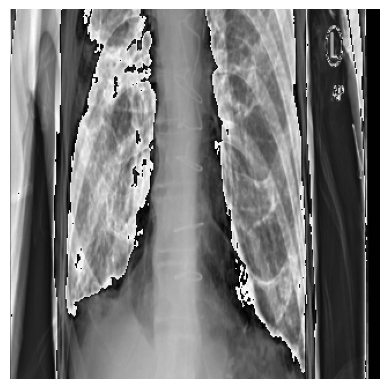

tensor(1.)


In [14]:
# Lấy ảnh và nhãn đầu tiên từ dataset
image, label = test_dataset[9]

# chuyển sang numpy và đưa về [H,W,C]
if isinstance(image, torch.Tensor):
    image = f.to_pil_image(image)
plt.imshow(image) 
plt.axis("off")
plt.show()
print(label)

In [ ]:
net = ResNet50()
lr = 0.005
batch_size = 32
epochs = 100
net, train_losses, train_accuracies, val_losses, val_accuracies = train(train_data=train_dataset,
                                            val_data=valid_dataset,
                                            test_dataset=test_dataset,
                                            net=net,
                                            lr=lr,
                                            optimizer='adam',
                                            batch_size=batch_size,
                                            epochs=epochs)

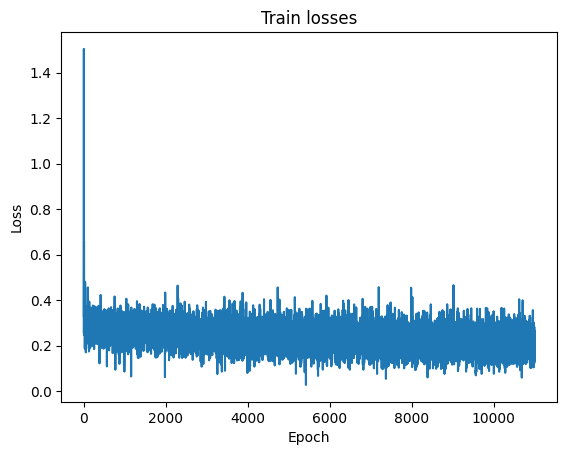

In [16]:
plt.plot(train_losses)
plt.title('Train losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

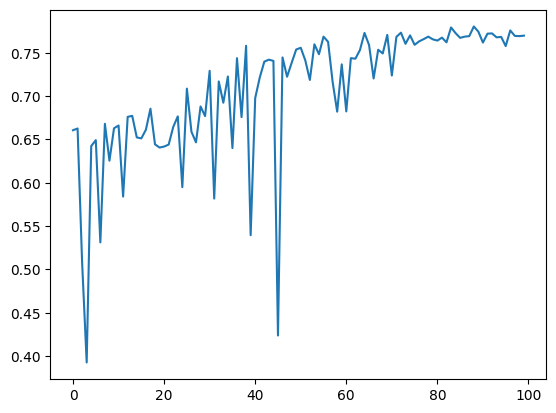

In [17]:
plt.plot(train_accuracies)

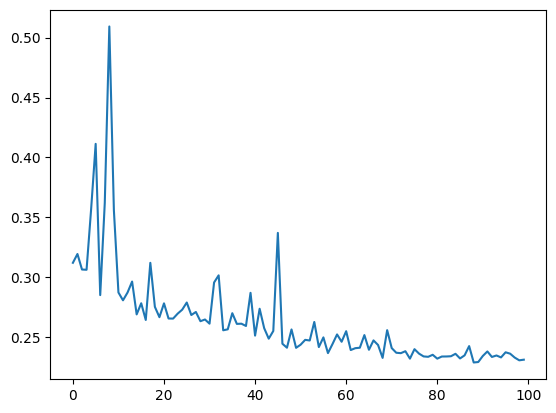

In [18]:
plt.plot(val_losses)

In [ ]:
print(evaluate(net, test_dataset))

In [20]:
torch.save(net, './model_Effusion.pth')